I recently got familiar with the Apple ecosystem due to receiving a new iPhone from my mom. (Thanks, mom!)  I have had a MacBook Pro since college and now have an iPhone to seamlessly do tasks together. So watching Apple's latest WWDC 2024 was only the next best thing in order to keep track their newest offerings. 

Goal: NLP/Sentiment Analysis on WWDC 2024 - what people liked, what were the most talked about releases, etc.

Performing this analysis will provide insight on how Apple is still in the game since people have been seeing it as behind on the AI front.

In [1]:
!pip install praw duckdb jupysql bertopic groq --quiet

In [2]:
import os
from pprint import pprint

# math
from math import *
import math

# API's
import googleapiclient.discovery #YouTube
import googleapiclient.errors
import praw # Reddit
from praw.models import MoreComments
from kaggle_secrets import UserSecretsClient

# Data Manipulations
import re
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
from datetime import datetime 

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

## Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Topic Modeling
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

from sklearn.feature_extraction.text import CountVectorizer

# Fast Language Model Inference
from groq import Groq

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Deploy Shiny apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-06-30 21:17:16.163583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 21:17:16.163848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 21:17:16.325489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get the data (YouTube and Reddit)
If there is not enough data, augment data with synonyms

API Links:
* [YouTube](https://console.cloud.google.com/apis/credentials?project=festive-zoo-404500)
* [Reddit](https://ssl.reddit.com/prefs/apps/)

YouTube Videos:
1. https://www.youtube.com/watch?v=qkYoBNdcXBU
1. https://www.youtube.com/watch?v=p2dhZ3AoDDs


Reddit Sub's:
1. https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/
1. https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/
1. https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/

In [3]:
user_secrets = UserSecretsClient()

In [4]:
# YouTube credentials
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = user_secrets.get_secret("youtube_apikey")

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [5]:
def getcomments(video):
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video,
        maxResults=100
    )

    comments = []

    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            comment['textOriginal'],
            comment['videoId']
        ])

    while (1 == 1):
        try:
            nextPageToken = response['nextPageToken']
        except KeyError:
            break
        nextPageToken = response['nextPageToken']
        # Create a new request object with the next page token.
        nextRequest = youtube.commentThreads().list(part="snippet", videoId=video, maxResults=100, pageToken=nextPageToken)
        # Execute the next request.
        response = nextRequest.execute()
        # Get the comments from the next response.
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            published_at = comment['publishedAt']
            comments.append([
                comment['authorDisplayName'],
                published_at,
                comment['likeCount'],
                comment['textOriginal'],
                comment['videoId']
            ])

    df0 = pd.DataFrame(comments, columns = ['author', 'published_at', 'like_count', 'text', 'video_id'])
    return df0

In [6]:
# Get all WWDC 2024 comments from YouTube

# vids = [MKBHD, Vox]
vids = ["qkYoBNdcXBU", "p2dhZ3AoDDs"]

df0 = pd.DataFrame()

for v in vids:
    df1 = getcomments(v)
    df0 = pd.concat([df0, df1]) # Combine all df's together into one big dataframe

df0.sample(5)

,author,published_at,like_count,text,video_id
3567,@aniketmathur2391,2024-06-11T17:45:06Z,0,I will never buy my kids an ipad ever in my life just coz of calculator app.....they will be even more dumber than they are supposed to in the future 😂😂😂😂😂,qkYoBNdcXBU
5276,@smdanny1,2024-06-11T13:38:21Z,0,AI = Apple Intelligence...,qkYoBNdcXBU
9548,@pranavjain5317,2024-06-11T07:33:02Z,0,Is call recording officially a feature by apple? Or is it just a rumour?,qkYoBNdcXBU
5303,@yonath94k,2024-06-11T13:35:38Z,0,"iOS sounds a lot like Android now. Not bad, Apple. Not bad.",qkYoBNdcXBU
5261,@jurt00,2024-06-11T13:40:26Z,0,"I was going to switch to Android for customization, but now there’s no point. I just need to wait a few more months.",qkYoBNdcXBU


In [7]:
# Proper date formats
df0['published_at'] = pd.to_datetime(df0['published_at'], format='%Y-%m-%dT%H:%M:%SZ')
df0['published_at_date'] = df0['published_at'].dt.date
df0['published_at_month'] = df0['published_at'].dt.month

In [8]:
# Rename video id's to appropriate video maker
df0['video_id'] = df0['video_id'].map({'qkYoBNdcXBU' : 'MKBHD', 'p2dhZ3AoDDs' : 'The Verge'})
df0.rename(columns = {'video_id':'youtube_channel'}, inplace=True)
df0.sample(5)

,author,published_at,like_count,text,youtube_channel,published_at_date,published_at_month
2749,@King4s,2024-06-11 21:01:52,0,You forgot one thing that was important to you. Vision os 2 can now store your setup room by room,MKBHD,2024-06-11,6
8574,@kevinyoungii9720,2024-06-11 08:17:55,0,The color grading of this video… bravo bravo 👏🏾. It looks like it was done with davinci resolve 👀,MKBHD,2024-06-11,6
61,@bryangopan,2024-06-11 06:05:12,0,😪😴🛌,The Verge,2024-06-11,6
4260,@Kixuu-onyt,2024-06-11 15:53:41,0,Showing Nothing OS monochrome homescreen as an example rather than googles material u would have been a better option.,MKBHD,2024-06-11,6
3319,@kyleharms2313,2024-06-11 18:30:06,0,Reading all Apple event notes off of a Samsung. Love it haha,MKBHD,2024-06-11,6


In [9]:
df0['youtube_channel'].value_counts()

youtube_channel
MKBHD        9838
The Verge     483
Name: count, dtype: int64

In [10]:
df0['app'] = 'YouTube'

In [11]:
len(df0)

10321

In [12]:
# Reddit credentials
reddit = praw.Reddit(client_id=user_secrets.get_secret("reddit_client_id"),
                     client_secret=user_secrets.get_secret("reddit_client_secret"),
                     user_agent=user_secrets.get_secret("reddit_user_agent"))

In [13]:
# get all-level Reddit comments for all Reddit posts
def reddit_comments(url):

    all_level_comments = []

    submission = reddit.submission(url=url)

    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        published_at = str(datetime.fromtimestamp(comment.created)) #UTC
        published_at = pd.to_datetime(published_at, format='%Y-%m-%d %H:%M:%S')
        all_level_comments.append({
            "author": comment.author,
            "published_at": published_at, 
            "published_at_date": published_at.date(),
            "published_at_month": published_at.month,
            "like_count": comment.score,
            "text": comment.body
        })

    all_comments_df = pd.DataFrame(all_level_comments)
    return all_comments_df

In [14]:
# Define function to get dataframe for all Reddit comments
def combo_dataframe(links):
    df = pd.DataFrame()
   
    for l in links:
        df2 = reddit_comments(l)
        df = pd.concat([df, df2]) # Combine all df's together into one big dataframe
    return df

In [15]:
# get WWDC 2024 posts' all-level Reddit comments

reddit_links = ['https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/',
                 'https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/',
                 'https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/'] 

reddit_df = combo_dataframe(reddit_links)

In [16]:
reddit_df.head()

author        published_at published_at_date  \
0          BCDragon3000 2024-06-10 18:45:13        2024-06-10   
1            Oulixonder 2024-06-10 18:45:23        2024-06-10   
2       hammerheadtiger 2024-06-10 18:44:49        2024-06-10   
3  ConflictedRedbird186 2024-06-10 18:45:04        2024-06-10   
4       BeefIsForDinner 2024-06-10 18:44:24        2024-06-10   

   published_at_month  like_count  \
0                   6         811   
1                   6         525   
2                   6         875   
3                   6         135   
4                   6          94   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [17]:
len(reddit_df)

1344

In [18]:
reddit_df['app'] = 'Reddit'

In [19]:
# Before concating YouTube and Reddit df's. see if their columns are equal.
list(reddit_df)

['author',
 'published_at',
 'published_at_date',
 'published_at_month',
 'like_count',
 'text',
 'app']

In [20]:
youtube_df = df0.drop(columns=['youtube_channel'], inplace=True)
youtube_df = df0

In [21]:
list(youtube_df)

['author',
 'published_at',
 'like_count',
 'text',
 'published_at_date',
 'published_at_month',
 'app']

In [22]:
# Combine YouTube df and Reddit df together
df = pd.concat([youtube_df, reddit_df])
len(df)

11665

In [23]:
df.head()

,author,published_at,like_count,text,published_at_date,published_at_month,app
0,@lovepassionpurpose3369,2024-06-30 20:59:46,0,Hakka tan,2024-06-30,6,YouTube
1,@luqman_azeem,2024-06-30 17:27:19,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,6,YouTube
2,@BoldmanJohniken,2024-06-30 12:47:45,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-06-30,6,YouTube
3,@user-sk4gj3ji3o,2024-06-30 12:41:42,0,Excellent reviews i was wondering about the feature as compare to chatgpt and Gemini?,2024-06-30,6,YouTube
4,@Carpediemdeluxe,2024-06-30 07:14:29,0,You’ve equaled Apple in subscribers! Well done!,2024-06-30,6,YouTube


# With only 12,000 samples, augment data using synonyms?

# Perform Bertopic Modeling

In [24]:
# No text pre-processing needed
docs = df['text']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-06-30 21:18:40,827 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/365 [00:00<?, ?it/s]

2024-06-30 21:20:17,965 - BERTopic - Embedding - Completed ✓
2024-06-30 21:20:17,966 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-30 21:20:54,276 - BERTopic - Dimensionality - Completed ✓
2024-06-30 21:20:54,278 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-30 21:21:04,608 - BERTopic - Cluster - Completed ✓
2024-06-30 21:21:04,618 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-30 21:21:24,437 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2775,-1_ai_siri_features_just,"[ai, siri, features, just, ios, video, google, screen, phones, update]","[Make a video of what's new on iPhones that's already been there on Android phones 😁, Marques, type to Siri is not a new feature on iOS!😂\nI’ve been using type to Siri for 5 plus years now!😂, **Lots** of great updates. There's so much to process. There are a handful of things that I didn't really like at first glance:\n\n1. All of the generative features. I didn't like how Microsoft started baking them into their software, and I don't really like them here. Can't place my finger on *why.* I feel like the Siri features are more essential for me. I'm **really** excited to play around with an enhanced Siri.\n2. The color-tinted icons. The effect reminds me of those cheap icon packs that circulated on the Play Store years ago. A developer would take official icons, add a tint, then dump them on the store en masse. I feel as though Apple heard the folks that have been wanting custom icon support, and this is some kind of stopgap.\n3. The Passwords app. I get this is going to be useful for many, many users that don't have good password management and hygiene. That said, I use Bitwarden. I really hope Apple doesn't begin to shove their Password solution down my throat.\n4. How blatantly ChatGPT branding is baked into the user-experience. Like, *whaaaat*? It feels very un-Apple to me. I love how native search engine support with auto-suggestions isn't supported on iOS — if you've ever tried to Google something from Spotlight, you probably know my pain — but I **can** have an OS-level supported ChatGPT conversation with ChatGPT branding? Wild. \n5. (Honestly, I'm glad they brought window snapping to Mac OS. That feature has been missing for so, so long. Stage Manager is not for me and never will be. That said, the 'old man' in me has really grown accustomed to my Swish + Alt-Tab setup. Hopefully I don't have to fight with these new OS features to continue using those tools.)\n6. (I find it ironic that the Settings app has become so complicated to navigate that a major sales pitch from today’s presentation was using the raw power of Apple’s flagship LLM to… navigate through settings. Not a complaint about the AI feature. Seems good. I’ll use it. I just feel that the Settings app has some other problems that seeing this feature triggered in my mind.)\n\nI get that there will be people that will use or benefit from these features, but as both a Software Engineer and consumer, feature bloat always makes me a little uncomfortable. That said, I’m very interested to get my hands on this release.]"
1,0,1002,0_calculator_ipad_handwriting_maths,"[calculator, ipad, handwriting, maths, note, students, high, pencil, homework, lol]","[You had me at calculator for iPad😂, Calculator on iPad 😂❤, iPad calculator app!!!]"
2,1,536,1_apple_stock_products_shit,"[apple, stock, products, shit, features, macos, catch, innovative, tech, customers]","[My main problem with apple products is how they have all these cool features that you would literally never know about just by looking at the product\n\nAll these features are buried under gestures and just non-intuitive things that you would never do if you didn't know the feature was there. \n\nLike you gotta know to randomly swipe down during a TV show to get info about the TV show. There isn't like a ""button"" that is labeled ""info"" that tells the user who doesn't know how to get to the info what to do. \n\nAnd at this point it seems like there are literally MILLIONS of little features like this baked into all the different platforms. \n\nIt's cool and easy to use if you're educated about how to use the products but if you're a beginner without an instruction manual how does apple expect anyone to figure all this stuff out?, Apple might always be late to the game with features but you know you're gonna get the best version of those features when App

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.

Let's see if different embeddings create more clear topics.


In [25]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(df['text'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
df['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-06-30 21:21:52,779 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-30 21:22:02,133 - BERTopic - Dimensionality - Completed ✓
2024-06-30 21:22:02,135 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-30 21:22:08,439 - BERTopic - Cluster - Completed ✓
2024-06-30 21:22:08,447 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-30 21:22:23,780 - BERTopic - Representation - Completed ✓


CPU times: user 1min 36s, sys: 21.5 s, total: 1min 57s
Wall time: 59.1 s


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4384,-1_apple_ai_features_android,"[apple, ai, features, android, like, years, ios, app, users, calculator]","[I will NEVER understand why Apple need to do ANY features that’s “been on android for years” I don’t care and don’t want it! If I wanted it, I’d buy an android🤷🏾‍♀️, AI = Apple intelligence., The ""calculator"" is pretty cool demo. But I'm going to wait until I see people use it before I go ""hey, I want that on my Android stuff"". Because the last time Apple said ""we can do handwriting recognition and stuff"" as an actual demo instead of rattling off features was... the Apple Newton. I'm still torn on AI in general, but that's not something to writeup here. I'm very glad they are going in on ""yea, this stays on device and we'll ask if you want to go off device"". I can't say I believe the ""private compute"" stuff but I'm sure someone will hook up some packet sniffing thing and work their way through as many features as they can and see at what point it starts talking to the internet.\n\nI do have to take issue with one comment that was said... ""they tried to say everything except AI, so they said machine learning and..."" 99% of what people see today, even OpenAI's ChatGPT, is machine learning. Nothing is ""intelligent"" here or from Google or Microsoft or OpenAI. Not only are their papers talking about ""AI hallucinations"" which give the appearance of intelligence without it being there, but there are enough limitations on how things are done that it's unlikely much outside of the many demos that get shown will function the way people expect. As someone on the internet said ""AI = what makes NPCs in video games do things and AI = complex scientific models... AI = non-generative tools to automate... AI = generative tools... it feels like deliberate obfuscation calling everything AI"" but I can tell you... some board members are thrilled about the money their making from the naming.]"
1,0,709,0_samsung_s24_ultra_notes,"[samsung, s24, ultra, notes, marques, mkbhd, updates, funny, ios, savage]","[Reading notes of a Samsung.., reading notes about apple on samsung😂😂, Reading IOS 18 new features from Samsung galaxy S24 Ultra's Notes app 😅😂😂]"
2,1,570,1_siri_type_accessibility_settings,"[siri, type, accessibility, settings, voice, chatgpt, bixby, languages, button, homepods]","[That it, so we can type to Siri now. 😴, You could already type to siri!, You could always type to siri]"
3,2,507,2_icons_apps_widgets_homescreen,"[icons, apps, widgets, homescreen, looks, button, colors, tint, customize, center]","[I didn't even know you couldn't move icons on the home screen on iOS\n\nHow the fuck do people use that thing 😂😂😂😂, Home Screen customization is why i don’t like android phones..now its on the iPhone, I really want to know if i can keep the ""normal"" color icons when in dark mode. I hate how the black icons look]"
4,3,475,3_lighting_hotel_videos_awt37x,"[lighting, hotel, videos, awt37x, thank, channel, setup, quality, studio, mkbhd]","[Lighting in this hotel is amazing, I’m wondering what kinda of camera and lighting you used for that video, looks amazing 🤩 is it your superior video editing skills or just great hotel room + professional lighting ? I’m just curious\nGreat video as always 👏🏻👏🏻, Man the lighting in your hotel room is crazy]"
...,...,...,...,...,...
90,89,18,89_gpt_chat_access_premium,"[gpt, chat, access, premium, subscription, standard, throttled, fuckload, separated, integration]","[so many questions, biggest one is if you pay for a premium chat gpt account do you get enhanced features? or more importantly is the version incorprated into ios just standard chat gpt 3,0? because if the iphone can use chat gpt 4.0 as standard whats the point in getting a premium account with open ai?, Both. By default (when using OpenAI) it will use the latest GPT-4o for free and paid users. If you have a paid account, you can sign in and get access to paid feature

In [26]:
topic_model.get_topic(0) # top topic

[('samsung', 0.0969418716490417),
 ('s24', 0.0521776920296481),
 ('ultra', 0.04911819582110143),
 ('notes', 0.037676121037595545),
 ('marques', 0.0322022144628489),
 ('mkbhd', 0.03178666919321542),
 ('updates', 0.019531516213437527),
 ('funny', 0.01507479819498199),
 ('ios', 0.013461507915450702),
 ('savage', 0.01073528067388312)]

These topics seem more interpretable due to better embeddings.

#### BERTopic Visualizations 
Reference: https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-probablities-or-distribution

In [27]:
topic_model.visualize_topics()

The biggest topic after the outlier topic (0) was topic 1 which was about Siri. I used the slider to highlight the bubble. When you hover over the bubble, you see the words associated with the topic.

In [28]:
topic_model.visualize_barchart(top_n_topics=8)

Looks like some other huge topics were criticism of Apple being behind in development including the AI frontier. Though a huge win was the showcasing of the interactive/predictive calculator.

In [29]:
topic_model.visualize_heatmap()

# Perform Sentiment and Emotion Classification

* Not sure what the benchmark is for good separation between topics. 
* Considering topics not along the diagonal and not associated with topic 0.  
* Most topics are 0.4 or below in similarity score. This means there are nice distinct topics discovered under better embeddings and BERTopic model.

In [30]:
# using Hugging Face sentiment classifier trained on pre-trained on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

I need to take care of long comments. Will use an LLM to summarize down to the necessary amount of sentences. Will need to use a Tokenizer to determine max sentences for summary cut-off.

Using cased model so case-sentitive text used to train model. so for inference, no need for lowering text

In [31]:
# Need to make comments text as similar as it was for model training for sentiment inference: remove HTML tags
# Need to also get rid of weird tags since model was not trained on that for inference

def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', ' ').replace('\t', '')
    
df['processed_text'] = df.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
df.head(5)

,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text
0,@lovepassionpurpose3369,2024-06-30 20:59:46,0,Hakka tan,2024-06-30,6,YouTube,"[0.02961690165102482, 0.009589482098817825, 0.003837511409074068, 0.05467256158590317, 0.07176852226257324, -0.01749909482896328, -0.02704254724085331, 0.01837528683245182, -0.06861735880374908, 0.024410409852862358, -0.06400389969348907, -0.07322365045547485, -0.018358705565333366, 0.03488822653889656, -0.0016196592478081584, -0.05144859105348587, 0.028744325041770935, 0.02249639295041561, 0.024105453863739967, -0.06399448215961456, 0.06254211813211441, 0.04268711432814598, -0.03821496665477753, -0.060437023639678955, 0.05268263444304466, 0.004052627366036177, 0.021813862025737762, 0.03304392471909523, 0.05589577555656433, 0.03798016533255577, 0.049959369003772736, -0.006211350206285715, 0.0080731101334095, -0.04364095255732536, 0.042967263609170914, 0.021337609738111496, 0.011522485874593258, -0.052636899054050446, -0.06882260739803314, -0.009127365425229073, -0.04744728282094002, -0.018881453201174736, 0.032367583364248276, 0.004790226463228464, -0.027545670047402382, 0.002963034436106682, -0.045771289616823196, -0.02823169156908989, -0.06543052941560745, 0.06383493542671204, 0.010488562285900116, 0.06543252617120743, 0.045701704919338226, -0.027591092512011528, 0.051752787083387375, 0.010599597357213497, 0.021693456918001175, 0.04889389127492905, 0.053591880947351456, -0.010998360812664032, -0.033208414912223816, 0.021241914480924606, 0.012455080635845661, 0.027687784284353256, -0.027040600776672363, -0.03035917691886425, -0.04482463747262955, -0.019474074244499207, 0.06786032021045685, 0.07224348932504654, 0.026089735329151154, -0.0641685202717781, -0.026418602094054222, 0.019052129238843918, -0.020692044869065285, 0.0716438740491867, 0.019778842106461525, 0.005132270976901054, -0.07330270856618881, 0.037008464336395264, 0.084771066904068, 0.08036743849515915, -0.04799436032772064, -0.031211836263537407, 0.014805286191403866, -0.011585297994315624, -0.032393068075180054, 0.01883232221007347, -0.05027485638856888, -0.025133375078439713, -0.05171967297792435, 0.03375543653964996, 0.052347294986248016, 0.05567741394042969, 0.015581740997731686, 0.003804950276389718, -0.03596014529466629, -0.05547856539487839, -0.019796472042798996, 0.01207458321005106, ...]",Hakka tan
1,@luqman_azeem,2024-06-30 17:27:19,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,6,YouTube,"[0.04365967959165573, -0.03889032080769539, -0.0039003847632557154, -0.0060868640430271626, -0.04915812984108925, -0.05031649395823479, 0.0546540692448616, -0.012213803827762604, 0.06709223985671997, 0.03647138550877571, -0.021133873611688614, 0.023709073662757874, -0.0779908075928688, 0.07200521230697632, -0.09417862445116043, 0.08897290378808975, 0.05794050171971321, 0.01601570099592209, 0.016240788623690605, -0.03530426323413849, -0.06705400347709656, 0.02541515976190567, -0.01876853220164776, 0.01963202841579914, -0.013048859313130379, 0.08765191584825516, -0.023046119138598442, 0.02064356580376625, -0.028591427952051163, -0.0230097658932209, -0.041817374527454376, -0.008346081711351871, -0.08445580303668976, 0.04661286994814873, -0.014290496706962585, -0.03017202578485012, -0.027652474120259285, -0.002569488249719143, -0.025476297363638878, -0.056150857359170914, 0.0789279192686081, 0.0015706141712144017, 0.04094575718045235, 0.02180231362581253, 0.07694856822490692, -0.020554741844534874, -0.014089280739426613, -0.028738435357809067, 0.029350100085139275, 0.015799369663000107, -0.07578103989362717, 0.07350799441337585, 0.07697395235300064, 0.018144482746720314, -0.09353232383728027, 0.0164260882884264, -0.029899150133132935, -0.03228568285703659, 0.020491870120167732, 0.034405417740345, 0.03159399703145027, -0.04511510580778122, -0.

In [32]:
# %%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. 
# Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 450 total words as max total words per comments since tokenizer can add suffixes as a token
#2. eliminate token lengths greater than max/SUMMARIZE comments using Grok since losing richness of dataset with eliminating comments

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['num_tokens'] = df.apply(lambda row: len(tokenizer.tokenize(row.processed_text)), axis = 1)
df.head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text,num_tokens
0,@lovepassionpurpose3369,2024-06-30 20:59:46,0,Hakka tan,2024-06-30,6,YouTube,"[0.02961690165102482, 0.009589482098817825, 0.003837511409074068, 0.05467256158590317, 0.07176852226257324, -0.01749909482896328, -0.02704254724085331, 0.01837528683245182, -0.06861735880374908, 0.024410409852862358, -0.06400389969348907, -0.07322365045547485, -0.018358705565333366, 0.03488822653889656, -0.0016196592478081584, -0.05144859105348587, 0.028744325041770935, 0.02249639295041561, 0.024105453863739967, -0.06399448215961456, 0.06254211813211441, 0.04268711432814598, -0.03821496665477753, -0.060437023639678955, 0.05268263444304466, 0.004052627366036177, 0.021813862025737762, 0.03304392471909523, 0.05589577555656433, 0.03798016533255577, 0.049959369003772736, -0.006211350206285715, 0.0080731101334095, -0.04364095255732536, 0.042967263609170914, 0.021337609738111496, 0.011522485874593258, -0.052636899054050446, -0.06882260739803314, -0.009127365425229073, -0.04744728282094002, -0.018881453201174736, 0.032367583364248276, 0.004790226463228464, -0.027545670047402382, 0.002963034436106682, -0.045771289616823196, -0.02823169156908989, -0.06543052941560745, 0.06383493542671204, 0.010488562285900116, 0.06543252617120743, 0.045701704919338226, -0.027591092512011528, 0.051752787083387375, 0.010599597357213497, 0.021693456918001175, 0.04889389127492905, 0.053591880947351456, -0.010998360812664032, -0.033208414912223816, 0.021241914480924606, 0.012455080635845661, 0.027687784284353256, -0.027040600776672363, -0.03035917691886425, -0.04482463747262955, -0.019474074244499207, 0.06786032021045685, 0.07224348932504654, 0.026089735329151154, -0.0641685202717781, -0.026418602094054222, 0.019052129238843918, -0.020692044869065285, 0.0716438740491867, 0.019778842106461525, 0.005132270976901054, -0.07330270856618881, 0.037008464336395264, 0.084771066904068, 0.08036743849515915, -0.04799436032772064, -0.031211836263537407, 0.014805286191403866, -0.011585297994315624, -0.032393068075180054, 0.01883232221007347, -0.05027485638856888, -0.025133375078439713, -0.05171967297792435, 0.03375543653964996, 0.052347294986248016, 0.05567741394042969, 0.015581740997731686, 0.003804950276389718, -0.03596014529466629, -0.05547856539487839, -0.019796472042798996, 0.01207458321005106, ...]",Hakka tan,3
1,@luqman_azeem,2024-06-30 17:27:19,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,6,YouTube,"[0.04365967959165573, -0.03889032080769539, -0.0039003847632557154, -0.0060868640430271626, -0.04915812984108925, -0.05031649395823479, 0.0546540692448616, -0.012213803827762604, 0.06709223985671997, 0.03647138550877571, -0.021133873611688614, 0.023709073662757874, -0.0779908075928688, 0.07200521230697632, -0.09417862445116043, 0.08897290378808975, 0.05794050171971321, 0.01601570099592209, 0.016240788623690605, -0.03530426323413849, -0.06705400347709656, 0.02541515976190567, -0.01876853220164776, 0.01963202841579914, -0.013048859313130379, 0.08765191584825516, -0.023046119138598442, 0.02064356580376625, -0.028591427952051163, -0.0230097658932209, -0.041817374527454376, -0.008346081711351871, -0.08445580303668976, 0.04661286994814873, -0.014290496706962585, -0.03017202578485012, -0.027652474120259285, -0.002569488249719143, -0.025476297363638878, -0.056150857359170914, 0.0789279192686081, 0.0015706141712144017, 0.04094575718045235, 0.02180231362581253, 0.07694856822490692, -0.020554741844534874, -0.014089280739426613, -0.028738435357809067, 0.029350100085139275, 0.015799369663000107, -0.07578103989362717, 0.07350799441337585, 0.07697395235300064, 0.018144482746720314, -0.09353232383728027, 0.0164260882884264, -0.029899150133132935, -0.03228568285703659, 0.020491870120167732, 0.034405417740345, 0.03159399703145027, -0.045115105

In [33]:
# Now let us take a look at comments composition that have the highest token length

query = """
select author
, num_tokens
, processed_text
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

466 is the number of tokens closest to 450 and still exceeding it. Let's take a look at the number of sentences that these comments are comprised of in order to get a total sentence target for summarization.

In [34]:
# Sentence Count
df['sent_count'] = df['processed_text'].str.count('[\w][\.!\?]')

In [35]:
query = """
select author
, num_tokens
, processed_text
, sent_count
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Try to use open source LLM/Fast Language Model (groqcloud) to summarize Pandas text column
Reference: https://console.groq.com/docs/quickstart

In [36]:
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
            Here is the original comment:
            i want to thank you for always giving us a well thought videos. others spend time babbling and trying to be funny and you sound like a tech guy giving us tech news. i have a suggestion to take you to a new level. i have been writing apple for years. i honestly believe they have used some of my ideas. i’ll share them in a moment. by the way i am a software engineer. i am not one who thinks i am so d smart or the smarted person in the room. i love to always learn and ai find i am always learning new things from you. so my idea for you is a real tech news channel. this will make you something like the wal mart of tech news. this idea could put some tech influencers out of business with this idea. i tried to float this to apple but they don’t seem to like the idea. we have cnn, nbc news, abc news, cbs news and from time to time we get tech news but mostly when something new like a new iphone is released. tech news is happening every day all day. i say join forces with some of the best like yourself, brian tong, possibly some from engadget and create a real tech news channel. it’s not based around politics although t today politics and tech seem to collide. evs and republicans wanting to k evs, tictok, twitter. with social media companies being as influential as they have become. they’re not on the hot seat enough with cameras in their face or reporters running up on them to ask difficult questions. a real tech news channel will do this. what you and others do is journalism. i want the news to still be fun but i want it just like real news every day 24/7 just like a cnn. you will hire anchors do some in-depth interviews like we see you do often with tech ceo’s. it’s a militia billion. dollar idea i am giving to you. this is something new of its kind and needed. tech is no longer just mobile. we have stepped into the world of ai and humans need to understand how these new pieces of tech will i pack them. i would love to work with you as a producer or something. i have a huge idea and it will work.	31
            
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

"Here is a condensed version of the original comment:\n\nI want to thank you for creating well-thought-out videos that provide genuine tech news, unlike others who focus on being funny or witty. As a software engineer, I've been writing to Apple for years, and I believe they've implemented some of my ideas. I'm not trying to act like I'm the smartest person in the room, I just love learning and appreciate your content. My idea is to create a real tech news channel, similar to CNN or NBC News, but focused solely on technology. This channel would provide in-depth interviews and daily tech news 24/7, covering topics like AI, EVs, and social media. I think this idea could disrupt the tech influencer market and make you a leading authority in the field. I've already tried pitching this idea to Apple, but they weren't interested. I'd love to work with you as a producer or contributor to bring this idea to life."

In [37]:
# Exclude chat bot intro portion as whole inference
spl_word = '\n\n'
res = chat_completion.choices[0].message.content.split(spl_word, 1)
res[1]

"I want to thank you for creating well-thought-out videos that provide genuine tech news, unlike others who focus on being funny or witty. As a software engineer, I've been writing to Apple for years, and I believe they've implemented some of my ideas. I'm not trying to act like I'm the smartest person in the room, I just love learning and appreciate your content. My idea is to create a real tech news channel, similar to CNN or NBC News, but focused solely on technology. This channel would provide in-depth interviews and daily tech news 24/7, covering topics like AI, EVs, and social media. I think this idea could disrupt the tech influencer market and make you a leading authority in the field. I've already tried pitching this idea to Apple, but they weren't interested. I'd love to work with you as a producer or contributor to bring this idea to life."

In [38]:
#Let's check if this condensed version from Groq is <512/450 tokens in length
len(tokenizer.tokenize(res[1]))

195

* [x] Now write up a function in order to loop through Pandas text column that has >450 tokens 
* [x] Put responses in a list
* [x] Add summaries to df 
* [x] Now run tokenizer
* [x] Check to make sure that each row now has 500 or less tokens
* After verification, perform sentiment and emotion analysis possibly using HF and Groq

In [39]:
query = """
select *
from df
where num_tokens >450
"""

summarize_df = duckdb.query(query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [40]:
condensed = []
for text in summarize_df['processed_text']:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": '''

                Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
                Here is the original comment:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    spl_word = '\n\n'
    res = chat_completion.choices[0].message.content.split(spl_word, 1)
    condensed.append(res[1])

In [41]:
condensed[1]

'WWDC\'s iPad calculator app is a gimmick that will likely gather dust. Even MKBHD, a renowned tech reviewer, called it the only "incredible feature" from WWDC, but I believe it\'s overhyped. The app can provide answers as you write down a math question, adjust variables, and add graphs, but these features are only useful for primary school-level math. Beyond 4th grade, students need to manipulate equations and show their work, making the app unnecessary. A physical calculator is faster, easier, and more representative of exam conditions. The TI-Nspire calculator, specifically, blows the iPad\'s math notes feature out of the water in terms of functionality and features.\n\nAdditionally, alternatives like Geogebra and Desmos offer more features for free, making the iPad\'s math notes feature redundant. The novelty of the app is appealing, but it doesn\'t hold up in real-world context. The hype surrounding the app is similar to the hype surrounding humanoid robots, which are impressive i

In [42]:
summarize_df['processed_text'][1]

"My take on WWDC's iPad calculator app: It's nothing more than a gimmick WWDC just dropped yesterday and one of the highlight features was the calculator app feature. MKBHD, the gold standard reviewer to go to when it comes to technology, called it the only “incredible feature” that came to the iPad. But like almost every other hyped software/AI update these days, they hardly get used by us in the real world. Ok, let’s dive into the main Math Notes features that everyone is so excited about and I will explain why they are all useless gimmicks: It’s able to give you answers as you write down a maths question. You can adjust the information in your math question and the answer will update accordingly. It can support variables and equations, and you can manipulate them all you want. You can add graphs in the notes and demonstrate the function as you manipulate the numbers. The features listed above are pretty cool, but if we were to put them in a real-world context, they instantly become 

Very nice condensed version of >500 token comment. Now let us combine the two lists into two Pandas columns. And then join this to the original df on the non-condensed. And finally, create a new column that has >=500 tokens non-condensed and condensed text.

In [43]:
summarize_df['condensed_text'] = condensed

In [44]:
# Compare/Check original comment to condensed versions

query = """
select processed_text
, condensed_text
from summarize_df
"""
sum_df = duckdb.query(query).df()
sum_df

processed_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [45]:
df.tail(1)

,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text,num_tokens,sent_count
314,Outlulz,2024-06-12 17:56:48,1,"And they underestimate how much those power users need apps that aren't feature limited in various ways, as iPad apps often are.",2024-06-12,6,Reddit,"[0.036374252289533615, 0.0018887761980295181, 0.013794825412333012, -0.024645032361149788, 0.07509668916463852, 0.02978736162185669, -0.014666731469333172, 0.02737509459257126, -0.08639979362487793, -0.021323813125491142, -0.02128777839243412, 0.026287972927093506, 0.010250294581055641, 0.019341735169291496, -0.08800721913576126, 0.08082183450460434, 0.05634509399533272, 0.07507498562335968, -0.007823888212442398, -0.01930375024676323, 0.00040937503217719495, -0.01521317008882761, -0.03623389080166817, -0.056619010865688324, 0.025124400854110718, 0.08912590146064758, -0.05415944755077362, -0.04539085552096367, -0.03022334910929203, -0.007936901412904263, -0.06654814630746841, 0.03164670988917351, -0.012801454402506351, 0.0017922954866662621, -0.0171522069722414, -0.030316216871142387, 0.020496021956205368, -0.010173262096941471, -0.009121425449848175, -0.007060904521495104, 0.08494159579277039, 0.06523647159337997, 0.05202324688434601, 0.002727554412558675, 0.07034624367952347, 0.05289119482040405, 0.028464797884225845, -0.003093899693340063, 0.02114252932369709, -0.022366249933838844, -0.05657031387090683, -0.021899262443184853, 0.014888421632349491, 0.015242040157318115, -0.08869249373674393, 0.04491349682211876, -0.03258330747485161, 0.015954814851284027, -0.01349815633147955, 0.003267280524596572, -0.007392035331577063, 0.011291200295090675, 0.06271562725305557, -0.05778924748301506, -0.03213762119412422, 0.044282302260398865, 0.0006875956314615905, -0.021303564310073853, -0.051589880138635635, -0.05974290519952774, -0.08748854696750641, 0.045968472957611084, 0.04342393949627876, 0.07218178361654282, 0.0440196618437767, 0.03777280077338219, 0.0431390181183815, -0.060950566083192825, 0.04557739570736885, 0.07643826305866241, 0.01301841251552105, 0.012988467700779438, -0.03918759524822235, 0.008744411170482635, 0.025889072567224503, -0.02924429066479206, 0.03847343102097511, -0.018668897449970245, 0.0728556364774704, 0.046057675033807755, -0.014093147590756416, 0.06307815760374069, -0.003745617810636759, -0.04806207865476608, 0.01593032106757164, -0.018451888114213943, 0.02801472507417202, 0.0839536041021347, -0.036595817655324936, -0.06460487842559814, ...]","And they underestimate how much those power users need apps that aren't feature limited in various ways, as iPad apps often are.",28,1


In [46]:
# Combine summarized df back to original

query = """
select author
, like_count
, text as original_text
, published_at_date
, app
, t1.processed_text
, condensed_text
from (select * exclude (published_at, published_at_month, use4, num_tokens, sent_count)
from df) t1
left join sum_df
on t1.processed_text = sum_df.processed_text

"""
summarized_df = duckdb.query(query).df()
summarized_df.head()

,author,like_count,original_text,published_at_date,app,processed_text,condensed_text
0,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,Hakka tan,None
1,@luqman_azeem,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,YouTube,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",None
2,@BoldmanJohniken,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-06-30,YouTube,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,None
3,@user-sk4gj3ji3o,0,Excellent reviews i was wondering about the feature as compare to chatgpt and Gemini?,2024-06-30,YouTube,Excellent reviews i was wondering about the feature as compare to chatgpt and Gemini?,None
4,@Carpediemdeluxe,0,You’ve equaled Apple in subscribers! Well done!,2024-06-30,YouTube,You’ve equaled Apple in subscribers! Well done!,None


In [47]:
len(summarized_df)

11665

In [48]:
# Create one column without NaN (coalesce) and eliminate extraneous columns before sentiment/emotion classification
# Compare/Check original comment to condensed versions

query = """
select author
, like_count
, original_text
, published_at_date
, app
, case when condensed_text IS NULL then processed_text else condensed_text end as final_text
from summarized_df
"""
inf_df = duckdb.query(query).df()
inf_df['final_text'] = inf_df.apply(lambda row: cleanhtml(row['final_text']), axis=1)
inf_df.head(5)

,author,like_count,original_text,published_at_date,app,final_text
0,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,Hakka tan
1,@luqman_azeem,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,YouTube,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?"
2,@BoldmanJohniken,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-06-30,YouTube,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.
3,@user-sk4gj3ji3o,0,Excellent reviews i was wondering about the feature as compare to chatgpt and Gemini?,2024-06-30,YouTube,Excellent reviews i was wondering about the feature as compare to chatgpt and Gemini?
4,@Carpediemdeluxe,0,You’ve equaled Apple in subscribers! Well done!,2024-06-30,YouTube,You’ve equaled Apple in subscribers! Well done!


In [49]:
inf_df.isnull().sum()

author               41
like_count            0
original_text         0
published_at_date     0
app                   0
final_text            0
dtype: int64

In [50]:
len(summarize_df)

10

In [51]:
query = """
select *
from inf_df
where author in (select author from summarize_df)
"""
duckdb.query(query).df()

author  like_count  \
0   @madboyreadynow28           0   
1     hammerheadtiger         100   
2     hammerheadtiger          10   
3     hammerheadtiger           3   
4        KLM_SpitFire           2   
5    @johnpearson1258           0   
6       @flowting5163           0   
7          @lellmajar           0   
8          @ThuanSuBa           0   
9   @madboyreadynow28           0   
10      @mndlessdrwer           0   
11      @hilal_younus           2   
12    hammerheadtiger         875   
13       KLM_SpitFire           2   
14           kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Great. /n is removed from text grabbed via API. Now let us re-tokenize the text to make sure we don't hit an error. 

In [52]:
inf_df['num_tokens'] = inf_df.apply(lambda row: len(tokenizer.tokenize(row.final_text)), axis = 1)

In [53]:
query = """
select max(num_tokens)
from inf_df
"""
duckdb.query(query).df()

,max(num_tokens)
0,446


In [54]:
# The sentiment classifier still had some comments that exceeded 512 tokens. So need to eliminate more comments...
query = """
select *
from inf_df
where num_tokens <=450
"""
inf_df2 = duckdb.query(query).df()

In [55]:
inf_df.drop(columns=['num_tokens'], inplace=True)
inf_df.head(1)

,author,like_count,original_text,published_at_date,app,final_text
0,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,Hakka tan


Great! Let us now get sentiment and emotion classifications.

In [56]:
len(inf_df)-len(inf_df2) # difference is small. so proceed.

0

## Sentiment Classification

In [57]:
%%time

inf_df2 = (
inf_df2.assign(sentiment = lambda x: x['final_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

inf_df2.head()

CPU times: user 16min 25s, sys: 2.58 s, total: 16min 28s
Wall time: 8min 14s


,author,like_count,original_text,published_at_date,app,final_text,num_tokens,sentiment,label,score
0,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,Hakka tan,3,"[{'label': 'positive', 'score': 0.49844303727149963}]",positive,0.498443
1,@luqman_azeem,0,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",2024-06-30,YouTube,"It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?",44,"[{'label': 'positive', 'score': 0.7958763241767883}]",positive,0.795876
2,@BoldmanJohniken,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-06-30,YouTube,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,43,"[{'label': 'positive', 'score': 0.9008601307868958}]",positive,0.900860
3,@user-sk4gj3ji3o,0,Excellent reviews i was wondering about the feature as compare to chatgpt and Gemini?,2024-06-30,YouTube,Excellent reviews i was wondering about the feature as compare to chatgpt and Gemini?,17,"[{'label': 'positive', 'score': 0.565340518951416}]",positive,0.565341
4,@Carpediemdeluxe,0,You’ve equaled Apple in subscribers! Well done!,2024-06-30,YouTube,You’ve equaled Apple in subscribers! Well done!,12,"[{'label': 'positive', 'score': 0.9039134383201599}]",positive,0.903913


In [58]:
inf_df2.tail(2)

,author,like_count,original_text,published_at_date,app,final_text,num_tokens,sentiment,label,score
11663,KLM_SpitFire,2,"**Lots** of great updates. There's so much to process. There are a handful of things that I didn't really like at first glance:\n\n1. All of the generative features. I didn't like how Microsoft started baking them into their software, and I don't really like them here. Can't place my finger on *why.* I feel like the Siri features are more essential for me. I'm **really** excited to play around with an enhanced Siri.\n2. The color-tinted icons. The effect reminds me of those cheap icon packs that circulated on the Play Store years ago. A developer would take official icons, add a tint, then dump them on the store en masse. I feel as though Apple heard the folks that have been wanting custom icon support, and this is some kind of stopgap.\n3. The Passwords app. I get this is going to be useful for many, many users that don't have good password management and hygiene. That said, I use Bitwarden. I really hope Apple doesn't begin to shove their Password solution down my throat.\n4. How blatantly ChatGPT branding is baked into the user-experience. Like, *whaaaat*? It feels very un-Apple to me. I love how native search engine support with auto-suggestions isn't supported on iOS — if you've ever tried to Google something from Spotlight, you probably know my pain — but I **can** have an OS-level supported ChatGPT conversation with ChatGPT branding? Wild. \n5. (Honestly, I'm glad they brought window snapping to Mac OS. That feature has been missing for so, so long. Stage Manager is not for me and never will be. That said, the 'old man' in me has really grown accustomed to my Swish + Alt-Tab setup. Hopefully I don't have to fight with these new OS features to continue using those tools.)\n6. (I find it ironic that the Settings app has become so complicated to navigate that a major sales pitch from today’s presentation was using the raw power of Apple’s flagship LLM to… navigate through settings. Not a complaint about the AI feature. Seems good. I’ll use it. I just feel that the Settings app has some other problems that seeing this feature triggered in my mind.)\n\nI get that there will be people that will use or benefit from these features, but as both a Software Engineer and consumer, feature bloat always makes me a little uncomfortable. That said, I’m very interested to get my hands on this release.",2024-06-10,Reddit,"I'm excited about the latest updates, but there are a few things that didn't sit well with me. I'm not a fan of the generative features, which feel like they're trying to replace Siri's functionality. I prefer more essential Siri features. I'm also not a fan of the color-tinted icons, which remind me of cheap icon packs from the Play Store. The new Passwords app seems useful for many users, but I already use Bitwarden, so I hope Apple doesn't push their solution on me. I'm also surprised by how prominently ChatGPT is featured, which feels un-Apple-like. I appreciate the new window snapping feature, but I'm not a fan of Stage Manager. The Settings app has become overwhelming, even with the new AI-powered navigation feature. As a software engineer and consumer, I worry about feature bloat, but I'm still excited to try out the new release.",203,"[{'label': 'negative', 'score': 0.36176493763923645}]",negative,0.361765
11664,kasakka1,0,"My takeaway was that across MacOS, iOS and iPadOS I found very few things that I could tell I would include in my daily use.\n\nI already use 1Password so Apple Passwords is not useful for me. I can already do corner splits with BetterTouchTool's snap functions. \n\nI could have used something like improvements to MacOS virtual desktop handling instead, e.g naming desktops, arranging them in some other manner than a horizontal line, separating desktops vs fullscreen apps etc. It's one feature I use every day that is woefully forgotten by Apple. And Microsoft for that matter

<Axes: >

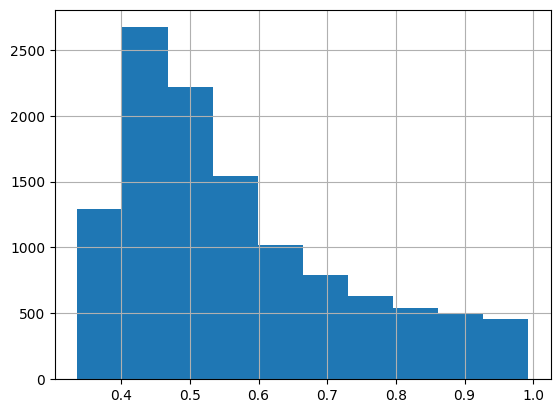

In [59]:
# From my own review, the sentiment classifier is not that accurate. Let's take a look at the score distribution to see confidence distribution.
inf_df2['score'].hist()

We can see here that the model is less than 50% sure on majority of its sentiment guess. This is not good and has to do with the data that it was trained on, how different it is from the data that it is predicting on now. Let us try to see grok's sentiment accuracy.

In [60]:
query = """
select author
, like_count
, original_text
, published_at_date
, app
, final_text
, label as hf_sentiment
, score as hf_score
from inf_df2
"""
inf_df2 = duckdb.query(query).df()

In [61]:
inf_df2.head(1)

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score
0,@lovepassionpurpose3369,0,Hakka tan,2024-06-30,YouTube,Hakka tan,positive,0.498443


In [62]:
# Need to chunk df into 100 rows at a time and feed into groq
list_df = np.array_split(inf_df2, math.ceil(len(inf_df2)/100))

In [63]:
%%time

#Checking to see if for loop without fxn works
groq_sentiment = [] # to store predictions
for text in list_df[0]['final_text']: #using one chunk of 100 rows only, looping through text fed into model
    chat_completion = client.chat.completions.create( #task performed on each comment
        messages=[
            {
                "role": "user",
                "content": '''

                Please classify the following comment with a sentument (negative, neutral or positive) as well as output your classification confidence as a score in percentage. Output only the sentiment and score as a python dictionary inside a list in consistent format. For example: [{'sentiment': sentiment prediction, 'score': score percentage}].
                This is the comment:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    res = chat_completion.choices[0].message.content
#     spl_word = '\n\n'
#     res = chat_completion.choices[0].message.content.split(spl_word, 1)
#     clean_res = re.findall(r'"([^"]*)"', res)

    groq_sentiment.append(res) #adding prediction to list to eventually append to df

CPU times: user 892 ms, sys: 55.9 ms, total: 948 ms
Wall time: 2min 55s


my_string="hello python world , i'm a beginner"
print(my_string.split("world",1)[1])

In [64]:
    spl_word = '\n\n'
    res = "Here is the classification:\n\n[{'sentiment': 'positive', 'score': 72}]".split(spl_word, 1)
    res
#     clean_res = re.findall(r'"([^"]*)"', res)

['Here is the classification:', "[{'sentiment': 'positive', 'score': 72}]"]

In [65]:
groq_sentiment[:10]

["Here is the classification:\n\n [{'sentiment': 'neutral', 'score': 80}]",
 "Here is the sentiment classification output:\n\n [{'sentiment': 'positive', 'score': 87.5}]",
 "Here is the classification:\n\n [{'sentiment': 'positive', 'score': 99}]",
 "Here is the classification:\n\n [{'sentiment': 'positive', 'score': 66}]",
 "Here is the classification:\n\n[{'sentiment': 'positive', 'score': 95}]",
 "[{'sentiment': 'positive', 'score': 88.46}]",
 "Here is the classification:\n\n [{'sentiment': 'neutral', 'score': 85}]",
 "Here is the classification:\n\n[\n    {'sentiment': 'negative', 'score': 90}\n]\n\nNote: The model is highly confident in its classification, scoring the sentiment as negative with 90% confidence.",
 "Here is the classification result:\n\n [{'sentiment': 'negative', 'score': 90}]",
 "Here is the classification output in the format you requested:\n\n[{'sentiment': 'neutral', 'score': 82}]"]

In [66]:
list_df[0]['final_text'][:10]

0                                                                                                                                                                                         Hakka tan
1    It's great that Apple will ask for permission everytime it wants to use ChatGPT. The big question is: when it uses cloud compute, does it process the data to upgrade its own LLM accordingly?
2              I really love your taste and style always so chic. My faves would be the  kislux   leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.
3                                                                                                             Excellent reviews i was wondering about the feature as compare to chatgpt and Gemini?
4                                                                                                                                                   You’ve equaled Apple in subscribers! Well done!
5                   

In [67]:
# def groq_pred (df):
#     groq_sentiment = []
#     for text in df['final_text']:
#         something
#     return final

In [68]:
# %%time
# all_pred = []

# for sub_df in list_df[0]:
#     all_pred.append(groq_pred(sub_df))

In [69]:
# Make all predictions from chunks into one big list to add to original inf_df2

# flattened_list = list(itertools.chain(*all_pred))
# flattened_list[:2].head(5)

## Emotion Classification

In [70]:
# Need to lower text for inference since emotion model trained on uncased text
# inf_d2f['final_text'] = inf_d2f['final_text'.str.lower()]

In [71]:
# using Hugging Face sentiment classifier trained on pre-trained model on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

# %%time
# emotion_model = pipeline(model="bhadresh-savani/distilbert-base-uncased-emotion")
# inf_df2= (
# inf_df2.assign(emotion1 = lambda x: x['final_text'].apply(lambda s: emotion_model(s)))
#     .assign(
#          emotion = lambda x: x['emotion1'].apply(lambda s: (s[0]['label']))
#     )
# )

# inf_df2.drop(columns=['emotion1'], inplace=True)
# inf_df2.head()

## Sentiment and Emotion over Time

In [72]:
type(inf_df2['published_at_date'])

pandas.core.series.Series

In [73]:
# For YouTube and Reddit users

# # Convert the date column to datetime
# df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# # Extract year and month from the date column
# df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

# # Group by hf_sent_label and year_month and count occurrences
# df_grouped = df_filtered.groupby(['hf_sent_label', 'year_month']).size().reset_index(name='count')

# # Pivot the data for plotting
# df_pivot = df_grouped.pivot(index='year_month', columns='hf_sent_label', values='count').fillna(0)

# # Plot the results
# df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
# plt.title('Sentiment Count for "Restaurants, Mexican" by Year-Month')
# plt.xlabel('Year-Month')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.legend(title='Sentiment Count Broken Down by Year-Month for Top Restaurant Category')
# plt.show()

# Aspect Based Sentiment Analysis (ASBA) Using PyABSA

# Named Entity Recognition in order to isolate products?

# Radar Graph between 2 similar, close in proximity restaurants 